In [1]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir("/content/gdrive/My Drive/OwnJupyterNotebooks/")
os.getcwd()

'/content/gdrive/My Drive/OwnJupyterNotebooks'

### Importing libraries

In [0]:
# re-install Tensorflow 2
#!pip install --pre -U tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals



In [5]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.0.0


In [6]:
# Import the data
(train_data, test_data), info = tfds.load(
    # Pre-encoded data set with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [0]:
# using the info.encoder module
encoder = info.features['text'].encoder

In [8]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [9]:
# Encoding is reversible
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [10]:
# See how encoder works
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [11]:
# Split the data
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())


Encoded text: [ 249    4  277  309  560    6 6639 4574    2   12]
Label: 1


In [12]:
encoder.decode(train_example)

"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens

### Preparing the Data

In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes))

In [14]:

for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 1201)
label shape: (32,)
Batch shape: (32, 716)
label shape: (32,)


### Building the Model

In [15]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')]) # Specifying the embedding layer and activation function

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) # binary_crossentropy useful for binary models

### Training the Model

In [17]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 15s 19ms/step - loss: 0.6805 - accuracy: 0.6349 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 0.6140 - accuracy: 0.7592 - val_loss: 0.5868 - val_accuracy: 0.7906
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.5322 - accuracy: 0.8128 - val_loss: 0.5228 - val_accuracy: 0.8125
Epoch 4/10
782/782 [==============================] - 11s 15ms/step - loss: 0.4663 - accuracy: 0.8437 - val_loss: 0.4676 - val_accuracy: 0.8438
Epoch 5/10
782/782 [==============================] - 12s 15ms/step - loss: 0.4162 - accuracy: 0.8663 - val_loss: 0.4271 - val_accuracy: 0.8573
Epoch 6/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3748 - accuracy: 0.8777 - val_loss: 0.3960 - val_accuracy: 0.8635
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3424 - accuracy: 0.8884 - val_loss: 0.3724 - val_a

In [18]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3297 - accuracy: 0.8774
Loss:  0.32967519716304894
Accuracy:  0.87736


In [19]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

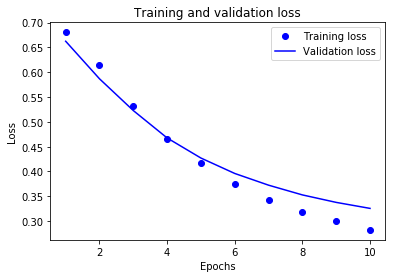

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

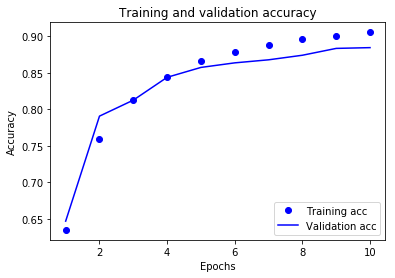

In [21]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()